In [1]:
import polars as pl
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cmocean import cm as cmo
import glidertools as gt

In [2]:
dat = xr.open_dataset("C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/pomBODCREQ-5915/unit_345/nc_files/L0-timeseries/Biocarbon_cabot.nc", chunks={"time": 1000})

In [3]:
glider_name = dat.attrs['glider_name']

In [4]:
mask = (dat.depth < 400).compute()
dat_surf = dat.where(mask, drop=True)

In [5]:
# gt.plot(dat_surf['profile_index'], dat_surf['depth'], dat_surf['backscatter_700'], cmap=cmo.delta)
# plt.title('b$_{bp}$ (m$^{-1}$)')
# plt.show()

In [6]:
theta = 124
xfactor = 1.076

In [7]:
bbp_1d = np.array(dat_surf['backscatter_700'])
prof_1d = np.array(dat_surf['profile_index'])
depth_1d = np.array(dat_surf['pressure'])

nan_mask = np.isnan(depth_1d)
valid_idx = np.where(~nan_mask)[0]  # Indices of non-NaN values
valid_values = depth_1d[valid_idx]   # Non-NaN values
depth_1d[nan_mask] = np.interp(np.where(nan_mask)[0], valid_idx, valid_values)


#bbp_horz = gt.cleaning.horizontal_diff_outliers(prof_1d, depth_1d, bbp_1d, depth_threshold=10, mask_frac=0.05)
bbp_baseline, bbp_spikes = gt.cleaning.despike(bbp_1d, 7, spike_method='minmax')
bbp_baseline_corrected = gt.flo_functions.flo_bback_total(bbp_baseline, dat_surf['temperature'].data, dat_surf['salinity'].data, theta, 700, xfactor)

# fig, ax = plt.subplots(3, 1, figsize=[9, 6], sharex=True, dpi=90)

# gt.plot(prof_1d, depth_1d, bbp_1d, cmap=cmo.delta, ax=ax[0], robust=True)
# gt.plot(prof_1d, depth_1d, bbp_baseline, cmap=cmo.delta, ax=ax[1], robust=True)
# gt.plot(prof_1d, depth_1d, bbp_spikes, ax=ax[2], cmap=plt.cm.Spectral_r, vmin=0, vmax=0.004)

# [a.set_xlabel('') for a in ax]

# ax[0].set_title('Raw b$_{bp}$ (m$^{-1}$)')
# ax[1].set_title('Despiked b$_{bp}$ (m$^{-1}$)')
# ax[2].set_title('b$_{bp}$ (m$^{-1}$) spikes')

# plt.show()

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [8]:
dat_surf['bbp700'] = ("time", bbp_baseline_corrected)

In [9]:
# mask = (dat_surf.profile_index > 0).compute()
# prof_i = dat_surf.where(mask, drop = True)

# bbp_raw = prof_i['backscatter_700']
# bbp_despiked = prof_i['bbp700']
# depths = prof_i['depth'].compute()

# plt.figure(figsize=(8, 6))
# #plt.plot(bbp_raw, depths, label='Backscatter Raw', color='blue')
# plt.scatter(bbp_despiked, depths, label='BBP Despiked', color='orange')

# plt.gca().invert_yaxis()  # Depth increases downwards
# plt.xlabel("Backscatter / BBP")
# plt.ylabel("Depth (m)")
# plt.xlim(0,0.01)
# plt.legend()
# plt.title("Profile 352: Despiking result")
# plt.grid(True)
# plt.show()


In [10]:
# gt.plot(dat_surf['profile_index'], dat_surf['depth'], dat_surf['chlorophyll'], cmap=cmo.delta)
# plt.title("Chlorophyll")
# plt.show()

In [11]:
flr_iqr = gt.cleaning.outlier_bounds_iqr(dat_surf['chlorophyll'], multiplier=1000)

In [12]:
flr_dark = gt.optics.fluorescence_dark_count(flr_iqr, dat_surf.depth)

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)


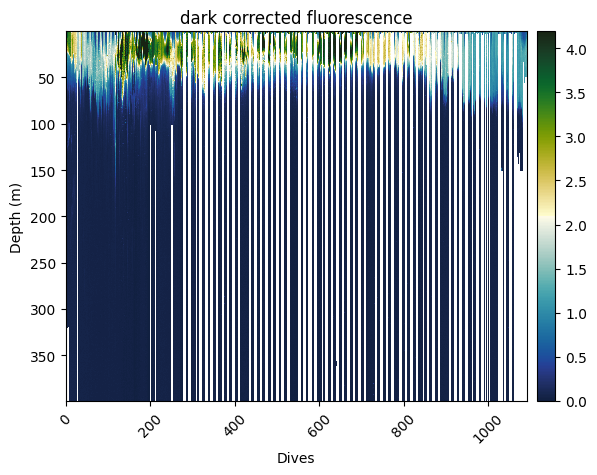

In [13]:
gt.plot(dat_surf['profile_index'], dat_surf['depth'], flr_dark, cmap=cmo.delta, robust=True)
plt.title('dark corrected fluorescence')
plt.show()

In [14]:
flr_base, flr_spikes = gt.cleaning.despike(flr_dark, 11, spike_method='median')

# fig, ax = plt.subplots(2, 1, figsize=[9, 6], sharex=True, dpi=90)

# gt.plot(dat_surf['profile_index'], dat_surf['depth'], flr_base, cmap=cmo.delta, ax=ax[0], robust=True)
# gt.plot(dat_surf['profile_index'], dat_surf['depth'], flr_spikes, cmap=plt.cm.RdBu_r, ax=ax[1], vmin=0, vmax=4)

# [a.set_xlabel('') for a in ax]
# [a.set_ylim(300, 0) for a in ax]

# ax[0].set_title('Despiked Fluorescence')
# ax[1].set_title('Fluorescence spikes')

# plt.show()

In [15]:
dat_surf = dat_surf.compute()

## Quenching correction

In the following cell we will perform quenching correction. 

The first step is to define night profiles, we selected every profiles between 10pm and 4am UTC, to be sure to avoid quenching. (Thus this can't be applied straight to other dataset where this time period might be quenched).
Then we define a fluo/bbp ratio on the first 40m of the profile, averaged.

On the day profiles, we identify the depth of the fluorescence maximum as the layer of potential quenching. We then compare the fluo/bbp ratio of the day profile to the night one. I it is lower that 95% of the night value (i.e. 5% difference) we recompute a corrected fluorescence as being bbp700 * fluo/bbp700_at_night

Everything is then appended back to the dataset. 

In [16]:
#convert our fluo bbp dataset to a polar dataframe because it is easier.
data = [
    pl.Series("datetime",  dat_surf.time.data, dtype=pl.Datetime),
    pl.Series("prof", dat_surf.profile_index.data, dtype=pl.Float64),
    pl.Series("depth", dat_surf.depth.data, dtype=pl.Float32),
    pl.Series("bbp", dat_surf.bbp700.data, dtype=pl.Float32),
    pl.Series("fluo", flr_base.data, dtype=pl.Float32),
]

df = pl.DataFrame(data)
df = df.with_columns((pl.col("fluo") / 2.5))
#define a function to detect if the profile is at day or night
def classify_day_night(dt):
    hour = dt.hour
    return "day" if 6 <= hour < 21 else "night"

# Add the new column
df = df.with_columns(
    pl.col("datetime").map_elements(lambda dt: classify_day_night(dt)).alias("day_night")
)

# Extract date part from datetime
df = df.with_columns(pl.col("datetime").dt.date().alias("date"))
df = df.with_columns(pl.col("depth").round(0).alias("depth_rounded"))
night_profiles = df.filter(
    (pl.col("day_night") == "night") & (pl.col("depth") <= 40)
)

# Compute the night fluo/bbp ratio
night_profiles = night_profiles.with_columns(
    (pl.col("fluo") / pl.col("bbp")).alias("fluo_bbp_ratio")
)

night_ratios_by_depth = night_profiles.group_by(["date"]).agg(
    pl.col("fluo_bbp_ratio").drop_nans().mean().alias("night_depth_ratio")
)

#compute the ratio for day profiles
day_profiles = df.filter(
    (pl.col("day_night") == "day") & (pl.col("depth") <= 40)
).with_columns(
    (pl.col("fluo") / pl.col("bbp")).alias("fluo_bbp_ratio")
)

#detect the quenched layer
quenched_layer = day_profiles.group_by("prof"
).agg(pl.col("fluo").drop_nans().max().alias("max_fluo_value")
)

max_depth_per_profile = (
    df.join(quenched_layer, on=["prof"])
    .filter(pl.col("fluo") == pl.col("max_fluo_value"))
    .select(["prof", "max_fluo_value", "depth"])
    .rename({"depth": "max_fluo_depth"})
).group_by(pl.col("prof")
).agg(pl.col("max_fluo_depth").drop_nans().mean())

# Join day profiles with corresponding night ratios by date and depth
day_profiles = day_profiles.join(
    night_ratios_by_depth, on=["date"], how="left"
).join(max_depth_per_profile, on = ["prof"], how = "left")
# Define a significant drop (e.g., 20% drop from night ratio)
day_profiles = day_profiles.with_columns(
    ((pl.col("fluo_bbp_ratio") < pl.col("night_depth_ratio") * 0.95) & (pl.col("depth") < pl.col("max_fluo_depth")))
    .alias("quenching_detected")
)
day_profiles = day_profiles.with_columns(
    pl.when(pl.col("quenching_detected"))
    .then(pl.col("bbp") * pl.col("night_depth_ratio"))
    .otherwise(pl.col("fluo"))
    .alias("fluo_unquenched")
)
df = df.join(day_profiles.select(["datetime", "depth", "fluo_unquenched"]), 
              on=["datetime", "depth"], how="left")

# Fill night profiles or uncorrected points with original fluo values
df = df.with_columns(
    pl.when(pl.col("fluo_unquenched").is_null())
    .then(pl.col("fluo"))
    .otherwise(pl.col("fluo_unquenched"))
    .alias("fluo_unquenched")
)

In [17]:
dat_surf['fluo_corrected'] = ("time", df["fluo_unquenched"])
dat_surf['fluo'] = ("time", df["fluo"])

In [18]:
# flr_qc, quench_layer = gt.optics.quenching_correction(
#     flr_base, dat_surf.bbp700, dat_surf.profile_index, dat_surf.depth, dat_surf.time.data.astype('datetime64[ms]'), dat_surf.latitude, dat_surf.longitude,
#     sunrise_sunset_offset=1, night_day_group = True, max_photic_depth = 50)

# fig, ax = plt.subplots(2, 1, figsize=[9, 6], sharex=True, dpi=90)

# gt.plot(dat_surf['profile_index'], dat_surf['depth'], flr_qc, cmap=cmo.delta, ax=ax[0], robust=True)
# gt.plot(dat_surf['profile_index'], dat_surf['depth'], quench_layer, cmap=plt.cm.RdBu_r, ax=ax[1], vmin=-.5, vmax=2)

# [a.set_xlabel('') for a in ax]
# [a.set_ylim(100, 0) for a in ax]

# ax[0].set_title('Quenching Corrected Fluorescence')
# ax[1].set_title('Quenching Layer')

# plt.show()

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

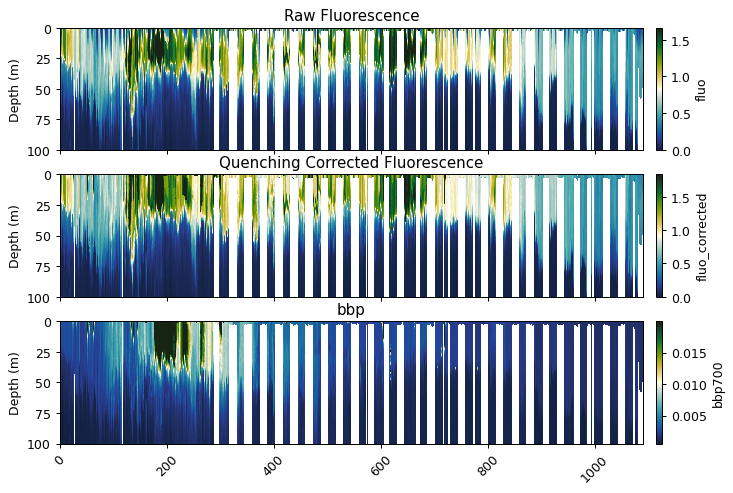

In [19]:
fig, ax = plt.subplots(3, 1, figsize=[9, 6], sharex=True, dpi=90)

gt.plot(dat_surf['profile_index'], dat_surf['depth'], dat_surf['fluo'], cmap=cmo.delta, ax=ax[0], robust=True)
gt.plot(dat_surf['profile_index'], dat_surf['depth'], dat_surf['fluo_corrected'], cmap=cmo.delta, ax=ax[1], robust=True)
gt.plot(dat_surf['profile_index'], dat_surf['depth'], dat_surf['bbp700'], cmap=cmo.delta, ax=ax[2])

[a.set_xlabel('') for a in ax]
[a.set_ylim(100, 0) for a in ax]
#[a.set_xlim(400, 450) for a in ax]

ax[0].set_title("Raw Fluorescence")
ax[1].set_title('Quenching Corrected Fluorescence')
ax[2].set_title('bbp')

plt.show()

In [20]:
dat_surf['fluo_dark'] = ("time", flr_dark.data)
#dat_surf['fluo_unquenched'] = ("time", flr_qc.data)

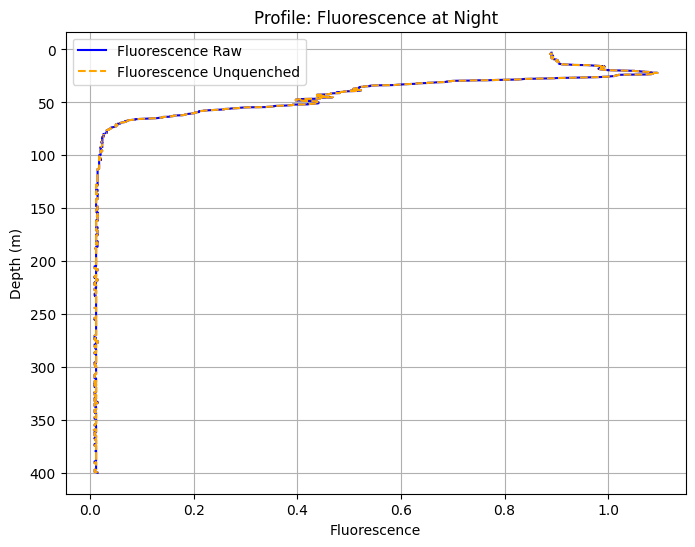

In [21]:
mask = (dat_surf.profile_index == 440).compute()
prof_i = dat_surf.where(mask, drop = True)

flr_raw = prof_i['fluo']
flr_unquenched = prof_i['fluo_corrected']
depths = prof_i['depth'].compute()

plt.figure(figsize=(8, 6))
plt.plot(flr_raw, depths, label='Fluorescence Raw', color='blue')
plt.plot(flr_unquenched, depths, label='Fluorescence Unquenched', color='orange', linestyle='--')

plt.gca().invert_yaxis()  # Depth increases downwards
plt.xlabel("Fluorescence")
plt.ylabel("Depth (m)")
plt.legend()
plt.title("Profile: Fluorescence at Night")
plt.grid(True)
plt.show()


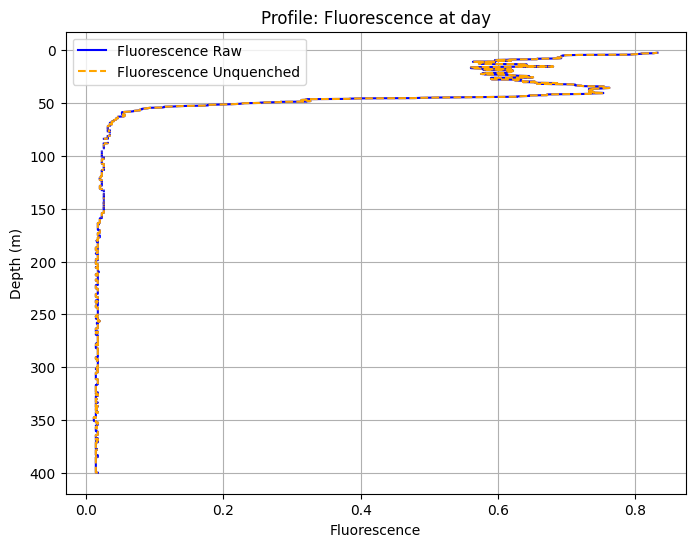

In [22]:
mask = (dat_surf.profile_index == 372).compute()
prof_i = dat_surf.where(mask, drop = True)

flr_raw = prof_i['fluo']
flr_unquenched = prof_i['fluo_corrected']
depths = prof_i['depth'].compute()

plt.figure(figsize=(8, 6))
plt.plot(flr_raw, depths, label='Fluorescence Raw', color='blue')
plt.plot(flr_unquenched, depths, label='Fluorescence Unquenched', color='orange', linestyle='--')

plt.gca().invert_yaxis()  # Depth increases downwards
plt.xlabel("Fluorescence")
plt.ylabel("Depth (m)")
plt.legend()
plt.title("Profile: Fluorescence at day")
plt.grid(True)
plt.show()

## PAR correction


In [23]:
if glider_name == "Nelson" or glider_name == "Churchill" :
    par_dark = gt.optics.par_fill_surface(dat_surf['par'].data, dat_surf['profile_index'].data, dat_surf['depth'].data)
    dat_surf['par_corr'] = ("time", par_dark.data)
    mask = (dat_surf.profile_index == 372).compute()
    prof_i = dat_surf.where(mask, drop = True)

    par_raw = prof_i['par']
    par_corr = prof_i['par_corr']
    depths = prof_i['depth'].compute()

    plt.figure(figsize=(8, 6))
    plt.plot(par_raw, depths, label='PAR Raw', color='blue')
    plt.plot(par_corr, depths, label='PAR corrected', color='orange', linestyle='--')

    plt.ylim([0, 50])

    plt.gca().invert_yaxis()  # Depth increases downwards
    plt.xlabel("PAR ue m-2")
    plt.ylabel("Depth (m)")
    plt.legend()
    plt.grid(True)
    plt.show()

## Satellite PAR matchup

In [24]:
import os

# Directory where your NetCDF files are stored (daily files)
ncdf_dir = "C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/satellite/par_mapped/"

# List all NetCDF files for the year (one file per day)
ncdf_files = sorted([f for f in os.listdir(ncdf_dir) if f.endswith('.nc')])

# Load the PAR data for each file and store it
daily_par_data = {}
for file in ncdf_files:
    # Open the dataset for the specific day
    ds = xr.open_dataset(os.path.join(ncdf_dir, file))
    
    # Extract PAR data (assuming it's named 'par', adjust if necessary)
    # Add a date key to use as the dictionary key for each day
    date = file.split('.')[1] # Extract the date from the filename (adjust based on filename format)
    
    # Store the data in a dictionary, with the date as the key
    daily_par_data[date] = ds["par"]  # Replace 'par' with the actual variable name in your files

# Example: inspect one of the datasets
print(daily_par_data["20240101"])  # Inspect the PAR data for January 1st, 2024

<xarray.DataArray 'par' (lat: 715, lon: 1468)> Size: 4MB
[1049620 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 3kB 70.03 69.99 69.95 69.9 ... 40.4 40.35 40.31 40.27
  * lon      (lon) float32 6kB -66.07 -66.03 -65.99 ... -5.024 -4.983 -4.941
Attributes:
    long_name:      Photosynthetically Available Radiation, R. Frouin
    units:          mol m^-2 day^-1
    standard_name:  surface_downwelling_photosynthetic_photon_flux_in_air
    valid_min:      -32750
    valid_max:      32250
    reference:      Frouin, R., Ligner, D.W., and Gautier, C., 1989: A Simple...
    display_scale:  linear
    display_min:    0.0
    display_max:    76.2


In [25]:
from scipy.spatial import cKDTree
import datetime

# Function to find the nearest PAR value for each observation
def get_nearest_par(lat, lon, date_str, daily_par_data):
    # Check if the date is in the daily PAR data
    if date_str in daily_par_data and daily_par_data[date_str].size > 0:
        # Get PAR data for that date and find the nearest point
        par_data = daily_par_data[date_str]
        nearest_par = par_data.sel(lon=lon, lat=lat, method='nearest').values.flatten()[0]
    else:
        nearest_par = 0  # Default if no data for that date
    return nearest_par

In [26]:
lon = dat_surf['longitude'].data
lat = dat_surf['latitude'].data
time =  [datetime.datetime.utcfromtimestamp(t.astype('datetime64[s]').astype(int)).strftime("%Y%m%d") for t in dat_surf['time'].data]
prof_index = dat_surf['profile_index'].data

df = pd.DataFrame({'lon' : lon, 'lat' : lat, 'time' : time, 'profile_index' : prof_index})
profile_means = (
    df.groupby("profile_index")[["lat", "lon"]]
    .mean()
    .reset_index()
)

In [27]:
dates_series = df.groupby(['profile_index','time']).size().reset_index().rename(columns={0:'count'})


In [28]:
df_to_match = pd.merge(profile_means, dates_series, how='left',on=['profile_index'])

In [29]:
df_to_match.head()

,profile_index,lat,lon,time,count
0,-0.0,59.490883,-19.926769,20240515,314
1,-0.0,59.490883,-19.926769,20240528,523
2,-0.0,59.490883,-19.926769,20240529,174
3,-0.0,59.490883,-19.926769,20240530,66
4,-0.0,59.490883,-19.926769,20240531,42


In [30]:
from tqdm import tqdm

# Step 3: Match PAR for each profile (with progress bar)
par_per_profile = []
for _, row in tqdm(df_to_match.iterrows(), total=len(df_to_match)):
    nearest_par = get_nearest_par(row["lat"], row["lon"], row["time"], daily_par_data)
    par_per_profile.append(nearest_par)

# Add PAR to the profile_means DataFrame
df_to_match["PAR_matched"] = par_per_profile

# Step 4: Merge PAR values back into the original DataFrame
df = df.merge(df_to_match[["profile_index", "PAR_matched"]], on="profile_index")

df.drop_duplicates(subset=['profile_index'], inplace = True)


100%|██████████| 1189/1189 [00:05<00:00, 229.20it/s]


In [31]:
df.head()

,lon,lat,time,profile_index,PAR_matched
0,-1.395268,50.892763,20240515,-0.0,34.084
41064,-23.981326,59.972407,20240528,1.0,31.264
43449,-23.980917,59.971686,20240528,2.0,31.264
43869,-23.982199,59.973623,20240528,3.0,31.264
47177,-23.980110,59.975518,20240528,4.0,31.264


In [32]:
df_xr = df.to_xarray

In [33]:
# Ensure DataFrame has the profile_index and PAR columns
df = df[["profile_index", "PAR_matched"]]

# Step 1: Merge DataFrame with xarray dataset's profile_index as a DataFrame
dat_surf_df = dat_surf.to_dataframe().reset_index()

# Step 2: Perform a left join on profile_index
merged_df = dat_surf_df.merge(df, on="profile_index", how="left")

# Step 3: Convert the merged DataFrame back into xarray
dat_surf = merged_df.set_index(["time"]).to_xarray()

# Step 4: Ensure the new PAR column is added properly
dat_surf['PAR'] = dat_surf['PAR_matched']
dat_surf = dat_surf.drop_vars('PAR_matched')  # Optional: drop the extra 'par' column


In [34]:
# Step 1: Keep only rows with depth between 0 and 201 meters
filtered_df = merged_df[(merged_df['depth'] >= 0) & (merged_df['depth'] <= 201)].copy()

# Step 2: Create 1-meter bins (0 to 201 inclusive)
filtered_df['depth_bin'] = np.floor(filtered_df['depth']).astype(int)

# Step 3: Group by profile and depth bin, then average values
averaged_df = (
    filtered_df
    .groupby(['profile_index', 'depth_bin'])
    .mean()
    .reset_index()
)

# Step 4: Sort for cleaner output
averaged_df = averaged_df.sort_values(['profile_index', 'depth_bin']).reset_index(drop=True)


In [35]:
averaged_df['BBP470'] = averaged_df['bbp700']/(470/400) 
averaged_df['carbon'] = 12128 * averaged_df['BBP470'] + 0.59

In [36]:
averaged_df['time'] = pd.to_datetime(averaged_df['time'])

# Extract year, month, and day into new columns
averaged_df['year'] = averaged_df['time'].dt.year
averaged_df['month'] = averaged_df['time'].dt.month
averaged_df['day'] = averaged_df['time'].dt.day

In [37]:
# Define the complete range of depth bins
depth_bins_full = list(range(201))

# Get the unique profile indices to ensure we process each profile separately
profile_indices = averaged_df['profile_index'].unique()

# Process each profile individually
new_rows = []
for profile in profile_indices:
    profile_df = averaged_df[averaged_df['profile_index'] == profile]
    
    # Only proceed if the profile has more than 180 rows
    if len(profile_df) > 180:
        existing_bins = set(profile_df['depth_bin'])
        missing_bins = [bin for bin in depth_bins_full if bin not in existing_bins]
        
        if missing_bins:
            # Take the first row of the existing profile to replicate
            first_row = profile_df.iloc[0].copy()
            
            for missing_bin in missing_bins:
                new_row = first_row.copy()
                new_row['depth_bin'] = missing_bin
                new_rows.append(new_row)

# Add the new rows to the original DataFrame if any rows were created
if new_rows:
    averaged_df = pd.concat([averaged_df, pd.DataFrame(new_rows)], ignore_index=True)

# Sort the DataFrame to keep depth_bin order neat
averaged_df = averaged_df.sort_values(by=['profile_index', 'depth_bin']).reset_index(drop=True)


In [38]:
def opp_befa(chl, irr, sst, dayL):
    if chl < 1.0:
        chl_tot = 38.0 * np.power(chl, 0.425)
    else:
        chl_tot = 40.2 * np.power(chl, 0.507)

    z_eu = 200.0 * np.power(chl_tot, (-0.293))

    if z_eu <= 102.0:
         z_eu = 568.2 * np.power(chl_tot, -0.746)

    if sst < -10.0:
        pb_opt = 0.0
    elif sst < -1.0:
        pb_opt = 1.13
    elif sst > 28.5:
        pb_opt = 4.0
    else:
        pb_opt = 1.2956 + 2.749e-1*sst + 6.17e-2*np.power(sst, 2) - \
            2.05e-2*np.power(sst, 3) + 2.462e-3*np.power(sst, 4) - \
            1.348e-4*np.power(sst, 5) + 3.4132e-6*np.power(sst, 6) - \
            3.27e-8*np.power(sst, 7)

    irrFunc = 0.66125 * irr / (irr + 4.1)

    npp = pb_opt * chl * dayL * irrFunc * z_eu

    return npp

def cal_dayL(lat, yDay):
    gamma = lat/180.0 * np.pi
    psi = yDay/365.0 * 2.0 * np.pi
    solarDec = (0.39637 - 22.9133*np.cos(psi) + 4.02543*np.sin(psi) - \
                0.38720*np.cos(2*psi) + 0.05200*np.sin(2*psi)) * np.pi/180.0
    r = -np.tan(gamma) * np.tan(solarDec)

    if r<=-1:
        return 24.0
    elif np.fabs(r)<1:
        return 24.0 * np.arccos(r) / np.pi
    else:
        return 0
    
def day_of_year(day, month, year=2024):
    return (datetime.date(year, month, day) - datetime.date(year, 1, 1)).days + 1

## CBPM application

In [39]:
def running_mean(array, window_size=5):
    kernel = np.ones(window_size) / window_size
    smoothed_array = np.convolve(array, kernel, mode='same')  # 'same' ensures the output matches input size
    return smoothed_array

In [40]:
from cbpm_argo import cbpm_argo
import numpy as np
from scipy.interpolate import interp1d
dfs = []
depth_grid = np.arange(0,200)

# Iterate through each unique profile index
for i in averaged_df['profile_index'].unique():
    # Filter for rows corresponding to the current 'JULD'
    temp_df = averaged_df[averaged_df['profile_index'] == i].iloc[0:200,].copy()  # Use `.copy()` to avoid warnings

    # Extract the pressure and chlorophyll values for interpolation
    pres_values = temp_df['depth_bin'].to_numpy()
    chl_values = temp_df['fluo_corrected'].to_numpy()
    carbon_values = temp_df['carbon'].to_numpy()
    temp_values = temp_df['temperature'].to_numpy()

    # Apply the running mean smoothing
    chl_smoothed = running_mean(chl_values, window_size=5)
    carbon_smoothed = running_mean(carbon_values, window_size=5)

    # Check for valid data before interpolation (avoid NaN values)
    mask = ~np.isnan(pres_values) & ~np.isnan(chl_values)
    pres_values = pres_values[mask]
    chl_values = chl_values[mask]
    carbon_values = carbon_values[mask]
    temp_values = temp_values[mask]

    # Interpolate the CHLA_ADJUSTED onto the depth grid (0 to 199)
    if len(pres_values) > 1:  # Ensure there's enough data to interpolate
        interpolator = interp1d(pres_values, chl_values, bounds_error=False, fill_value=np.nan)
        interpolated_chl = interpolator(depth_grid)
        
        interpolator = interp1d(pres_values, carbon_values, bounds_error=False, fill_value=np.nan)
        interpolated_carbon = interpolator(depth_grid)

        interpolator = interp1d(pres_values, temp_values, bounds_error=False, fill_value=np.nan)
        interpolated_temp = interpolator(depth_grid)
        
    else:
        # If only one point or no valid data, fill with NaN
        print(temp_df['profile_index'].unique())
        interpolated_chl = np.full(depth_grid.shape, np.nan)
        interpolated_carbon = np.full(depth_grid.shape, np.nan)

    # Now we can extract other values and apply the cbpm_argo function
    chl_z = interpolated_chl
    Cphyto_z = interpolated_carbon
    irr = temp_df['PAR_matched'].mean()  # Mean irradiance value
    year = int(temp_df['year'].mean())
    month = int(temp_df['month'].mean())
    day = int(temp_df['day'].mean())
    lat = temp_df['latitude'].mean()
    sst = interpolated_temp[0:5].mean()


    #calculation of daylength
    doy = day_of_year(day, month)
    day_length = cal_dayL(lat, doy)

    # Call the cbpm_argo function with interpolated data
    [pp_z, mu_z, par_z, prcnt_z, nutTempFunc_z, IgFunc_z, mzeu] = cbpm_argo(chl_z, Cphyto_z, irr, year, month, day, lat)

    #VGPM computation
    npp_vgpm = opp_befa(chl_z[0], irr, sst, day_length)

    size_max = len(temp_df)

    # Use .loc to explicitly assign new columns (expand results back into DataFrame)
    temp_df.loc[:, 'pp'] = pp_z[0:size_max]
    temp_df.loc[:, 'mu'] = mu_z[0:size_max]
    temp_df.loc[:, 'prcnt'] = prcnt_z[0:size_max]
    temp_df.loc[:, 'nutTempFunc'] = nutTempFunc_z[0:size_max]
    temp_df.loc[:, 'IgFunc'] = IgFunc_z[0:size_max]
    temp_df.loc[:, 'zeu'] = np.full(size_max, mzeu)
    temp_df.loc[:, 'npp_vgpm'] = np.full(size_max, npp_vgpm)

    # Append modified DataFrame to the list
    dfs.append(temp_df)


# Combine all DataFrames
final_df = pd.concat(dfs)

[117.]
[275.]
[277.]
[281.]
[291.]
[297.]
[311.]
[313.]
[317.]
[319.]
[321.]
[323.]
[327.]
[331.]
[335.]
[343.]
[345.]
[351.]
[353.]
[355.]
[357.]
[371.]
[379.]
[383.]
[385.]
[389.]
[393.]
[395.]
[397.]
[399.]
[401.]
[403.]
[407.]
[409.]
[413.]
[415.]
[417.]
[429.]
[439.]
[441.]
[443.]
[445.]
[447.]
[449.]
[453.]
[455.]
[461.]
[467.]
[469.]
[471.]
[473.]
[489.]
[495.]
[511.]
[515.]
[517.]
[521.]
[525.]
[527.]
[529.]
[531.]
[535.]
[545.]
[553.]
[557.]
[565.]
[569.]
[573.]
[577.]
[585.]
[587.]
[591.]
[593.]
[595.]
[609.]
[621.]
[637.]
[639.]
[645.]
[669.]
[675.]
[677.]
[683.]
[691.]
[695.]
[699.]
[703.]
[707.]
[711.]
[713.]
[727.]
[737.]
[745.]
[749.]
[757.]
[759.]
[763.]
[775.]
[804.]
[826.]
[828.]
[836.]
[854.]
[864.]
[870.]
[874.]
[882.]
[886.]
[892.]
[904.]
[906.]
[910.]
[918.]
[922.]
[926.]
[930.]
[936.]
[942.]
[950.]
[964.]
[966.]
[968.]
[996.]
[1004.]
[1006.]
[1016.]
[1018.]
[1020.]
[1022.]
[1038.]
[1040.]
[1050.]
[1054.]
[1056.]
[1060.]
[1062.]


In [41]:
dat_final = final_df.set_index(["time"]).to_xarray()

C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = Series(z).groupby([x, bins])  # -DB put z into the many bins (like 2D hist)
C:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\GliderTools\glidertools\mapping.py:969: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

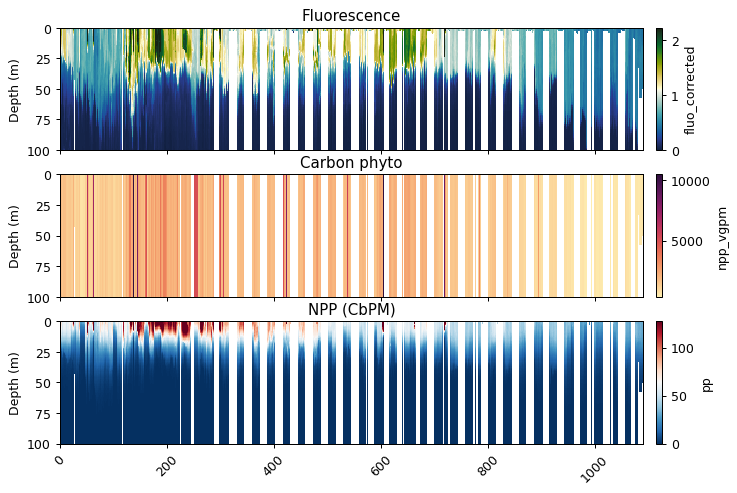

In [42]:
fig, ax = plt.subplots(3, 1, figsize=[9, 6], sharex=True, dpi=90)

gt.plot(dat_final['profile_index'], dat_final['depth'], dat_final['fluo_corrected'], cmap=cmo.delta, ax=ax[0], robust=True)
gt.plot(dat_final['profile_index'], dat_final['depth'], dat_final['npp_vgpm'], cmap=cmo.matter, ax=ax[1], robust=True)
gt.plot(dat_final['profile_index'], dat_final['depth'], dat_final['pp'], cmap=plt.cm.RdBu_r, ax=ax[2])

[a.set_xlabel('') for a in ax]
[a.set_ylim(100, 0) for a in ax]
#[a.set_xlim(265, 275) for a in ax]

ax[0].set_title("Fluorescence")
ax[1].set_title('Carbon phyto')
ax[2].set_title('NPP (CbPM)')

plt.show()

In [43]:
#dat_final = dat_final.drop_vars(['PAR_matched_x', 'PAR_matched_y'])
display(dat_final)
dat_final.to_netcdf('C:/Users/flapet/OneDrive - NOC/Documents/IDAPro/lib/db_building/data/glider/npp_ncdf/' + glider_name + '_npp.nc')

<xarray.Dataset> Size: 48MB
Dimensions:                (time: 145897)
Coordinates:
  * time                   (time) datetime64[ns] 1MB 2024-07-06T10:13:45.4647...
Data variables: (12/43)
    profile_index          (time) float64 1MB 0.0 0.0 ... 1.091e+03 1.091e+03
    depth_bin              (time) int64 1MB 0 1 2 3 4 5 6 ... 43 44 45 46 47 48
    latitude               (time) float64 1MB 60.29 61.84 59.97 ... 61.22 61.22
    longitude              (time) float64 1MB -20.76 -17.68 ... -21.69 -21.69
    heading                (time) float64 1MB 3.679 0.6773 0.797 ... 4.184 4.235
    pitch                  (time) float64 1MB -0.02645 -0.1051 ... 0.3639 0.2582
    ...                     ...
    mu                     (time) float64 1MB 0.3713 0.5958 1.998 ... nan nan
    prcnt                  (time) float64 1MB 1.006 0.8393 0.7185 ... nan nan
    nutTempFunc            (time) float64 1MB 0.1857 0.298 1.0 ... nan nan nan
    IgFunc                 (time) float64 1MB 0.9999 0.9996 0.9988 ... nan nan
    zeu                    (time) float64 1MB 22.0 22.0 22.0 ... nan nan nan
    npp_vgpm               (time) float64 1MB 1.252e+03 1.252e+03 ... nan nan